In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
model_dir = "/".join(os.getcwd().split("/")[:-1] + ['models'])
import models
from utils import test_accuracy, train_epoch, show_weights, model_prune, print_dims, get_kd_targets, get_weight_penalty
import copy
from tensorboardX import SummaryWriter
writer = SummaryWriter('tensorboard/runs/')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")

#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_full = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
use_cuda = torch.cuda.is_available()

## LeNet 300-100

### 1. Train Model

In [ ]:
model = models.LeNet_300_100()
#print_dims(model)

num_epochs = 100
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)
graph_title='original_model/'

model.cuda()
for epoch in range(num_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    
    test_acc = test_accuracy(test_loader, model, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model, get_loss=True)
    weight_penalty = get_weight_penalty(model)
    
    writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
    writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
    writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
    for name, param in model.named_parameters():
        writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        
    #print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], test_acc[0]))
    
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs))

### 2. Re-train Model

In [64]:
#Get KD Targets   
model_name = 'LeNet_300_100'
retraining_epochs=100
for temp in range (1,2):
    model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs)).cuda()
    train_kd_dataset = get_kd_targets(train_dataset, model, temp)
    train_kd_loader = torch.utils.data.DataLoader(dataset=train_kd_dataset, batch_size=batch_size, shuffle=True)

    #Load model
    model_kd = models.LeNet_300_100().cuda()
    model_kd.load_state_dict(model.state_dict())

    #Set up Optimisers and loss
    criterion_kd = nn.MSELoss()
    learning_rate_kd = 0.0005
    wd_kd = 0.0001
    optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

    graph_title = "compressed_model_T={}/".format(temp)

    for epoch in range(retraining_epochs):
        model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
        test_acc = test_accuracy(test_loader, model_kd, get_loss=True)
        train_acc = test_accuracy(train_loader_full, model_kd, get_loss=True)
        weight_penalty = get_weight_penalty(model_kd)

        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        if (epoch%10==9):
            print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
    torch.save(model_kd, model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs))
    show_weights(model_kd)

Epoch: 10. Train CE Loss: 1.519, Train Accuracy: 98.198, Test CE Loss: 1.523, Test Accuracy: 97.230, Model L2: 18.349


KeyboardInterrupt: 

### 3. Prune Model

In [6]:
temp = 3
model = torch.load(model_dir + 'mnist_LeNet_300_100_100.m').cuda()
model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_t{}_e100.m'.format(temp)).cuda()
model_c = models.LeNet_300_100().cuda()
pruner = model_prune(model_kd.state_dict())
deviation_list = [x/10.0 for x in range(0,21)]
percentile_list = range(0,101,5)
graph_title = "compressed_model_T={}/".format(temp)

In [7]:
test_acc_kd = test_accuracy(test_loader, model_kd, get_loss=True)
train_acc_kd = test_accuracy(train_loader_full, model_kd, get_loss=True)
weight_penalty_kd = get_weight_penalty(model_kd)

test_acc_o = test_accuracy(test_loader, model, get_loss=True)
train_acc_o = test_accuracy(train_loader_full, model, get_loss=True)
weight_penalty_o = get_weight_penalty(model)

In [8]:
dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
for lim in deviation_list:
    model_c.load_state_dict(pruner.deviation_prune(lim))
    test_acc = test_accuracy(test_loader, model_c, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_c, get_loss=True)
    weight_penalty = get_weight_penalty(model_c)
    
    dev_res['train ce'].append(train_acc[1])
    dev_res['test ce'].append(test_acc[1])
    dev_res['train acc'].append(train_acc[0])
    dev_res['test acc'].append(test_acc[0])
    dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
    dev_res['L2'].append(weight_penalty)
    
    print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
          .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))

Train CE Loss: 1.535, Train Accuracy: 98.160, Test CE Loss: 1.537, Test Accuracy: 97.440, Model L2: 16.621, Parameters Pruned: 0/266610 - 0.000%
Train CE Loss: 1.535, Train Accuracy: 98.157, Test CE Loss: 1.537, Test Accuracy: 97.410, Model L2: 16.623, Parameters Pruned: 155555/266610 - 58.346%
Train CE Loss: 1.535, Train Accuracy: 98.168, Test CE Loss: 1.537, Test Accuracy: 97.350, Model L2: 16.627, Parameters Pruned: 182364/266610 - 68.401%
Train CE Loss: 1.538, Train Accuracy: 98.065, Test CE Loss: 1.540, Test Accuracy: 97.340, Model L2: 16.604, Parameters Pruned: 191530/266610 - 71.839%
Train CE Loss: 1.540, Train Accuracy: 98.048, Test CE Loss: 1.541, Test Accuracy: 97.270, Model L2: 16.561, Parameters Pruned: 199105/266610 - 74.680%
Train CE Loss: 1.546, Train Accuracy: 97.947, Test CE Loss: 1.547, Test Accuracy: 97.240, Model L2: 16.500, Parameters Pruned: 205564/266610 - 77.103%
Train CE Loss: 1.555, Train Accuracy: 97.727, Test CE Loss: 1.555, Test Accuracy: 97.090, Model L2: 

In [10]:
perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []} 

for lim in percentile_list:
    model_c.load_state_dict(pruner.percentile_prune(lim))
    
    test_acc = test_accuracy(test_loader, model_c, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_c, get_loss=True)
    weight_penalty = get_weight_penalty(model_c)
    perc_res['train ce'].append(train_acc[1])
    perc_res['test ce'].append(test_acc[1])
    perc_res['train acc'].append(train_acc[0])
    perc_res['test acc'].append(test_acc[0])
    perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
    perc_res['L2'].append(weight_penalty)
    
    print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
          .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))

Train CE Loss: 1.535, Train Accuracy: 98.160, Test CE Loss: 1.537, Test Accuracy: 97.440, Model L2: 16.621, Parameters Pruned: 0/266610 - 0.000%
Train CE Loss: 1.535, Train Accuracy: 98.160, Test CE Loss: 1.537, Test Accuracy: 97.440, Model L2: 16.621, Parameters Pruned: 13310/266610 - 4.992%
Train CE Loss: 1.535, Train Accuracy: 98.165, Test CE Loss: 1.537, Test Accuracy: 97.400, Model L2: 16.621, Parameters Pruned: 26620/266610 - 9.985%
Train CE Loss: 1.535, Train Accuracy: 98.167, Test CE Loss: 1.537, Test Accuracy: 97.390, Model L2: 16.619, Parameters Pruned: 39930/266610 - 14.977%
Train CE Loss: 1.536, Train Accuracy: 98.118, Test CE Loss: 1.538, Test Accuracy: 97.350, Model L2: 16.613, Parameters Pruned: 53240/266610 - 19.969%
Train CE Loss: 1.537, Train Accuracy: 98.090, Test CE Loss: 1.539, Test Accuracy: 97.360, Model L2: 16.602, Parameters Pruned: 66550/266610 - 24.962%
Train CE Loss: 1.538, Train Accuracy: 98.078, Test CE Loss: 1.540, Test Accuracy: 97.270, Model L2: 16.583,

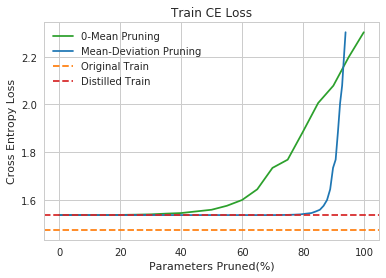

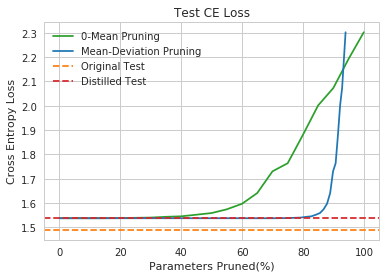

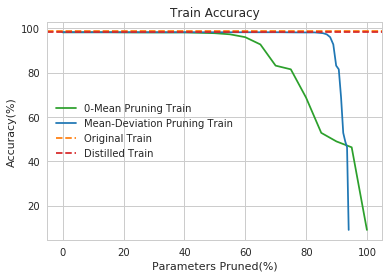

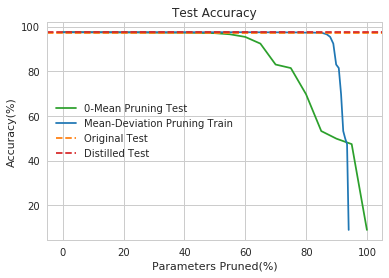

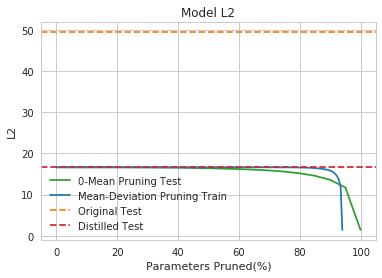

In [17]:
c1 = '#2ca02c'
c2 = '#1f77b4'
c3 = '#ff7f0e'
c4 = '#d62728'

plt.clf()
plt.plot(perc_res['pruned'], perc_res['train ce'], color = c1, label = "0-Mean Pruning")
plt.plot(dev_res['pruned'], perc_res['train ce'], color = c2, label = "Mean-Deviation Pruning")
plt.axhline(y=train_acc_o[1], label="Original Train", color = c3, linestyle='--')
plt.axhline(y=train_acc_kd[1], label="Distilled Train", color = c4, linestyle='--')
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=2)
plt.title("Train CE Loss")

plt.figure()
plt.plot(perc_res['pruned'], perc_res['test ce'], color = c1, label = "0-Mean Pruning")
plt.plot(dev_res['pruned'], perc_res['test ce'], color = c2, label = "Mean-Deviation Pruning")
plt.axhline(y=test_acc_o[1], label="Original Test", color = c3, linestyle='--')
plt.axhline(y=test_acc_kd[1], label="Distilled Test", color = c4, linestyle='--')
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=2)
plt.title("Test CE Loss")

plt.figure()
plt.plot(perc_res['pruned'], perc_res['train acc'], color = c1, label = "0-Mean Pruning Train")
plt.plot(dev_res['pruned'], perc_res['train acc'], color = c2, label = "Mean-Deviation Pruning Train")
plt.axhline(y=train_acc_o[0], label="Original Train", color = c3, linestyle='--')
plt.axhline(y=train_acc_kd[0], label="Distilled Train", color = c4, linestyle='--')
plt.ylabel("Accuracy(%)")
plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=6)
plt.title("Train Accuracy")

plt.figure()
plt.plot(perc_res['pruned'], perc_res['test acc'], color = c1, label = "0-Mean Pruning Test")
plt.plot(dev_res['pruned'], perc_res['test acc'], color = c2, label = "Mean-Deviation Pruning Train")
plt.axhline(y=test_acc_o[0], label="Original Test", color = c3, linestyle='--')
plt.axhline(y=test_acc_kd[0], label="Distilled Test", color = c4, linestyle='--')
plt.ylabel("Accuracy(%)")
plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=6)
plt.title("Test Accuracy")

plt.figure()
plt.plot(perc_res['pruned'], perc_res['L2'], color = c1, label = "0-Mean Pruning Test")
plt.plot(dev_res['pruned'], perc_res['L2'], color = c2, label = "Mean-Deviation Pruning Train")
plt.axhline(y=weight_penalty_o, label="Original Test", color = c3, linestyle='--')
plt.axhline(y=weight_penalty_kd, label="Distilled Test", color = c4, linestyle='--')
plt.ylabel("L2")
plt.xlabel("Parameters Pruned(%)")
plt.legend(loc=3)
plt.title("Model L2")

plt.show()

In [21]:
dummy_input = Variable(torch.rand(13, 1, 28, 28))

model_tb = models.LeNet_300_100().cuda()
with SummaryWriter(comment='LeNet_300_100') as w:
    w.add_graph(model_tb, (dummy_input, ))

add_graph() only supports PyTorch v0.2.


In [ ]:
plt.rcParams.update({'font.size': 14})
ps = [10, 100, 1000, 10000, 20000]
for dset in ['dev', 'tune', 'test']:
    plt.clf()
    for elem in ["w32k","bpe"]:
        label = "Word" if elem=="w32k" else "BPE"
        ps_arr = []
        for p in ps:
            ps_arr.append(ps_dict["{}_{}_{}".format(elem,dset,p)])
        p = plt.plot(ps,ps_arr, label="{} PS".format(label))
        plt.axhline(y=ct_dict["{}_{}".format(elem, dset)], color=p[-1].get_color(), label="{} CT".format(label), linestyle='-.')
    plt.xscale('log')  
    plt.xlim((10, 20000))
    plt.grid()
    plt.legend(loc=2)
    plt.xlabel("Number of Top Hypotheses")
    plt.ylabel("BLEU Score")
    #plt.show()
    plt.savefig('ps_{}.eps'.format(dset), format='eps', dpi=1000, bbox_inches='tight')